## initial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import QUANTAXIS as QA
import talib as ta
import datetime, time

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
start = '2000-01-01'
end = '2016-05-12'

In [4]:
code = '002149'

In [5]:
data = QA.QA_fetch_stock_day_adv(code, start, end)

In [6]:
data_hfq = data.to_hfq()

In [7]:
def MA_JCSC(dataframe, SHORT=5, LONG=10):
    """
    短时均线上传长时均线，买入信号参考；
    短时均线下穿长时均线，卖出信号参考.
    """
    CLOSE = dataframe.close
    MA_SHORT = CLOSE.rolling(SHORT).mean()
    MA_LONG = CLOSE.rolling(LONG).mean()
    
    CROSS_JC = QA.CROSS(MA_SHORT, MA_LONG)
    CROSS_SC = QA.CROSS(MA_LONG, MA_SHORT)
    
    return pd.DataFrame({'MA_SHORT':MA_SHORT, 'MA_LONG':MA_LONG,
                        'CROSS_JC':CROSS_JC, 'CROSS_SC':CROSS_SC})

In [8]:
Account = QA.QA_Account()
Broker = QA.QA_BacktestBroker()

In [9]:
Account.reset_assets(5e+5)
Account.account_cookie = 'MA_JCSC'

## 一些尝试

In [9]:
ind = data_hfq.add_func(MA_JCSC, 5, 10)

In [14]:
# ind.loc[('2007-08-15', '002149'), 'CROSS_JC'][0]

0

In [41]:
QA.QA_indicator_ATR??

In [ ]:
def backtest(dataframe, ind, Account, Broker, start, end):
    data_forbacktest = dataframe.select_time(start, end)
    
    for items in data_forbacktest.panel_gen:
    # item 为每只股票
    for item in items.security_gen:
        # daily_ind为每只股票对应的指标
        daily_ind = ind.loc[item.index]
        # 买入信号判断
        if daily_ind.CROSS_JC.iloc[0] > 0:
            # 下单：1.code;2.time;3.amount or price model;
            # 4. Buy or sell; 5.set price if price model;
            # 6.
            order = Account.send_order(
                code = item.code[0],
                time = item.date[0],
                amount = 2500,
                towards = QA.ORDER_DIRECTION.BUY,
                price = 0,
                order_model = QA.ORDER_MODEL.CLOSE,
                amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                )
            # Broker receive order: order and data
            Broker.receive_order(QA.QA_Event(order=order, market_data=item))
            
            # trade message
            trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
            # 233, order后面会自己tab出'account_cookie',是因为上一行中的
            # Account.account_cookie
            # result ?
            res = trade_mes.loc[order.account_cookie, order.realorder_id]
            # 交易id、价格、数量和时间
            order.trade(res.trade_id, res.trade_price, res.trade_amount,
                       res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0] > 0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order = Account.send_order(
                    code = item.code[0],
                    time = item.date[0],
                    amount = Account.sell_available.get(item.code[0], 0),
                    towards = QA.ORDER_DIRECTION.SELL,
                    price = 0,
                    order_model = QA.ORDER_MODEL.MARKET,
                    amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                
                trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                res = trade_mes.loc[order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                           res.trade_time)
    Account.settle()

In [19]:
data_forbacktest = data.select_time('2007-08-10', '2014-12-31')

for items in data_forbacktest.panel_gen:
    # item 为每只股票
    for item in items.security_gen:
        # daily_ind为每只股票对应的指标
        daily_ind = ind.loc[item.index]
        # 买入信号判断
        if daily_ind.CROSS_JC.iloc[0] > 0:
            # 下单：1.code;2.time;3.amount or price model;
            # 4. Buy or sell; 5.set price if price model;
            # 6.
            order = Account.send_order(
                code = item.code[0],
                time = item.date[0],
                amount = 2500,
                towards = QA.ORDER_DIRECTION.BUY,
                price = 0,
                order_model = QA.ORDER_MODEL.CLOSE,
                amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                )
            # Broker receive order: order and data
            Broker.receive_order(QA.QA_Event(order=order, market_data=item))
            
            # trade message
            trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
            # 233, order后面会自己tab出'account_cookie',是因为上一行中的
            # Account.account_cookie
            # result ?
            res = trade_mes.loc[order.account_cookie, order.realorder_id]
            # 交易id、价格、数量和时间
            order.trade(res.trade_id, res.trade_price, res.trade_amount,
                       res.trade_time)
        elif daily_ind.CROSS_SC.iloc[0] > 0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order = Account.send_order(
                    code = item.code[0],
                    time = item.date[0],
                    amount = Account.sell_available.get(item.code[0], 0),
                    towards = QA.ORDER_DIRECTION.SELL,
                    price = 0,
                    order_model = QA.ORDER_MODEL.MARKET,
                    amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                
                trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                res = trade_mes.loc[order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                           res.trade_time)
    Account.settle()

receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal

In [ ]:
_risk = QA.QA_Risk(Account)
_max_dropback = _risk.max_dropback
_target = _risk.profit / _risk.max_dropback
_df = pd.DataFrame({'N1':N1, 'N2':N2, 'target':_target})
df_result = pd.concat([df_result, _df], axis=0)

In [20]:
Risk = QA.QA_Risk(Account)     

In [23]:
Risk.max_dropback

0.08

In [56]:
Risk.profit

-0.01

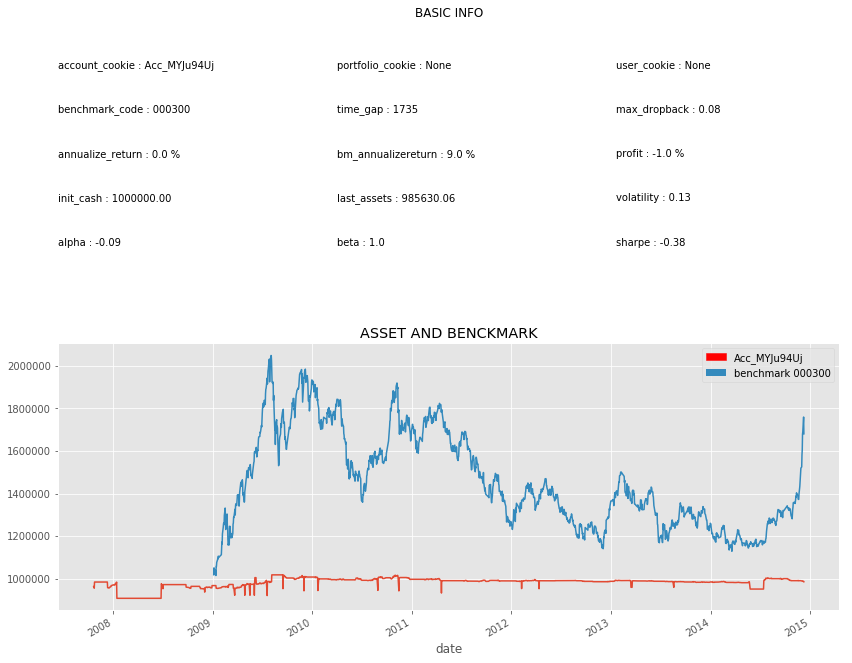

In [26]:
Risk.plot_assets_curve();

In [23]:
len(range(10, 31, 3))

7

In [28]:
data.date[-1]

Timestamp('2016-05-12 00:00:00')

In [9]:
df_result = pd.DataFrame()
count = 0
for N1 in range(5, 21, 2):
    for N2 in range(10, 31, 3):
        ind = data_hfq.add_func(MA_JCSC, N1, N2)
        Account.reset_assets(5e+5)
        
        data_forbacktest = data.select_time('2007-08-10', '2014-12-31')
        last_date = data_forbacktest.date[-1]
        for items in data_forbacktest.panel_gen:
            # item 为每只股票
            for item in items.security_gen:
                # daily_ind为每只股票对应的指标
                daily_ind = ind.loc[item.index]
                # 买入信号判断
                if daily_ind.CROSS_JC.iloc[0] > 0:
                    # 下单：1.code;2.time;3.amount or price model;
                    # 4. Buy or sell; 5.set price if price model;
                    # 6.
                    order = Account.send_order(
                        code = item.code[0],
                        time = item.date[0],
                        amount = 2500,
                        towards = QA.ORDER_DIRECTION.BUY,
                        price = 0,
                        order_model = QA.ORDER_MODEL.CLOSE,
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    # Broker receive order: order and data
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    # trade message
                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    # 233, order后面会自己tab出'account_cookie',是因为上一行中的
                    # Account.account_cookie
                    # result ?
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    # 交易id、价格、数量和时间
                    order.trade(res.trade_id, res.trade_price, res.trade_amount,
                               res.trade_time)
                elif daily_ind.CROSS_SC.iloc[0] > 0:
                    if Account.sell_available.get(item.code[0], 0)>0:
                        order = Account.send_order(
                            code = item.code[0],
                            time = item.date[0],
                            amount = Account.sell_available.get(item.code[0], 0),
                            towards = QA.ORDER_DIRECTION.SELL,
                            price = 0,
                            order_model = QA.ORDER_MODEL.MARKET,
                            amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                            )
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount,
                                   res.trade_time)
                if item.date[0] == last_date:
                    if Account.sell_available.get(item.code[0], 0)>0:
                        order = Account.send_order(
                            code = item.code[0],
                            time = item.date[0],
                            amount = Account.sell_available.get(item.code[0], 0),
                            towards = QA.ORDER_DIRECTION.SELL,
                            price = 0,
                            order_model = QA.ORDER_MODEL.MARKET,
                            amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                            )
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount,
                                   res.trade_time)
            Account.settle()
            
#         _risk = QA.QA_Risk(Account)
#         _max_dropback = _risk.max_dropback
#         _target = _risk.profit / _risk.max_dropback
        try:
            _df = pd.DataFrame({'N1':N1, 'N2':N2, 'target':Account.cash}, index=[count])
            df_result = pd.concat([df_result, _df], axis=0)
        except:
            pass

In [29]:
Account.cash

[500000.0]

### 使用随机搜索参数空间

In [32]:
N1 = np.random.choice(range(5,21))
N2 = np.random.choice(range(N1+1, 31))

15

In [60]:
df_result = pd.DataFrame()
count = 0
while count < 5:
    count += 1
    N1 = np.random.choice(range(5,21))
    N2 = np.random.choice(range(N1+1, 31))
    ind = data_hfq.add_func(MA_JCSC, N1, N2)
    Account.reset_assets(5e+5)

    data_forbacktest = data.select_time('2007-08-10', '2014-12-31')
    last_date = data_forbacktest.date[-1]
    for items in data_forbacktest.panel_gen:
        # item 为每只股票
        for item in items.security_gen:
            # daily_ind为每只股票对应的指标
            daily_ind = ind.loc[item.index]
            # 买入信号判断
            if daily_ind.CROSS_JC.iloc[0] > 0:
                # 下单：1.code;2.time;3.amount or price model;
                # 4. Buy or sell; 5.set price if price model;
                # 6.
                order = Account.send_order(
                    code = item.code[0],
                    time = item.date[0],
                    amount = 2500,
                    towards = QA.ORDER_DIRECTION.BUY,
                    price = 0,
                    order_model = QA.ORDER_MODEL.CLOSE,
                    amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                # Broker receive order: order and data
                Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                # trade message
                trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                # 233, order后面会自己tab出'account_cookie',是因为上一行中的
                # Account.account_cookie
                # result ?
                res = trade_mes.loc[order.account_cookie, order.realorder_id]
                # 交易id、价格、数量和时间
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                           res.trade_time)
            elif daily_ind.CROSS_SC.iloc[0] > 0:
                if Account.sell_available.get(item.code[0], 0)>0:
                    order = Account.send_order(
                        code = item.code[0],
                        time = item.date[0],
                        amount = Account.sell_available.get(item.code[0], 0),
                        towards = QA.ORDER_DIRECTION.SELL,
                        price = 0,
                        order_model = QA.ORDER_MODEL.MARKET,
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    order.trade(res.trade_id, res.trade_price, res.trade_amount,
                               res.trade_time)
            if item.date[0] == last_date:
                if Account.sell_available.get(item.code[0], 0)>0:
                    order = Account.send_order(
                        code = item.code[0],
                        time = item.date[0],
                        amount = Account.sell_available.get(item.code[0], 0),
                        towards = QA.ORDER_DIRECTION.SELL,
                        price = 0,
                        order_model = QA.ORDER_MODEL.MARKET,
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    order.trade(res.trade_id, res.trade_price, res.trade_amount,
                               res.trade_time)
        Account.settle()

#         _risk = QA.QA_Risk(Account)
#         _max_dropback = _risk.max_dropback
#         _target = _risk.profit / _risk.max_dropback
    try:
        final_cash = Account.history_table.cash.iloc[-1]
        _df = pd.DataFrame({'N1':N1, 'N2':N2, 'target':final_cash}, index=[count])
        df_result = pd.concat([df_result, _df], axis=0)
    except:
        pass

receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal

In [61]:
df_result

N1  N2        target
1  17  22  536829.43750
2  19  20  534783.78125
3  12  13  483310.43750
4  15  20  511617.97500
5  19  30  497745.14375

In [58]:
Account.cash_table[Account.cash_table.cash.isna()].head()

cash             datetime       date  \
datetime            account_cookie                                         
2010-04-20 00:00:00 MA_JCSC         None  2010-04-20 00:00:00 2010-04-20   
2010-04-22 00:00:00 MA_JCSC         None  2010-04-22 00:00:00 2010-04-22   
2010-05-05 00:00:00 MA_JCSC         None  2010-05-05 00:00:00 2010-05-05   
2010-06-18 00:00:00 MA_JCSC         None  2010-06-18 00:00:00 2010-06-18   
2010-07-02 00:00:00 MA_JCSC         None  2010-07-02 00:00:00 2010-07-02   

                                   account_cookie  
datetime            account_cookie                 
2010-04-20 00:00:00 MA_JCSC               MA_JCSC  
2010-04-22 00:00:00 MA_JCSC               MA_JCSC  
2010-05-05 00:00:00 MA_JCSC               MA_JCSC  
2010-06-18 00:00:00 MA_JCSC               MA_JCSC  
2010-07-02 00:00:00 MA_JCSC               MA_JCSC

In [59]:
Account.history_table.cash.iloc[-1]

512783.55624999956

In [49]:
Account.cash_table.loc['2009-01-22 00:00:00',slice(None)]

cash             datetime       date account_cookie
account_cookie                                                     
MA_JCSC         None  2009-01-22 00:00:00 2009-01-22        MA_JCSC

In [50]:
N1 = 11
N2 = 23
# 会出现cash_table None, 而history_table不出现None的问题

11

In [51]:
N2

23

In [ ]:
df_result = pd.DataFrame()
count = 0
for N1 in range(5, 21, 1):
    for N2 in range(10, 31, 1):
        if N1 >= N2:
            continue
        ind = data_hfq.add_func(MA_JCSC, N1, N2)
        Account.reset_assets(5e+5)

In [70]:
loop_count = 0
for N1 in range(5, 21, 1):
    for N2 in range(10, 31, 1):
        if N1 >= N2:
            continue
        

270


## 性能测试

In [19]:
Account.reset_assets(5e+5)
ind = data_hfq.add_func(MA_JCSC, 5, 10)

In [20]:
tic = time.process_time()
data_forbacktest = data.select_time('2007-08-10', '2014-12-31')

for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        daily_ind = ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0] > 0:
            order = Account.send_order(
                code = item.code[0],
                time = item.date[0],
                amount = 2500,
                towards = QA.ORDER_DIRECTION.BUY,
                price = 0,
                order_model = QA.ORDER_MODEL.CLOSE,
                amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                )
            Broker.receive_order(QA.QA_Event(order=order, market_data=item))
            
            trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
            res = trade_mes.loc[order.account_cookie, order.realorder_id]
            order.trade(res.trade_id, res.trade_price, res.trade_amount,
                       res.trade_time)
            
        elif daily_ind.CROSS_SC.iloc[0] > 0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order = Account.send_order(
                    code = item.code[0],
                    time = item.date[0],
                    amount = Account.sell_available.get(item.code[0], 0),
                    towards = QA.ORDER_DIRECTION.SELL,
                    price = 0,
                    order_model = QA.ORDER_MODEL.MARKET,
                    amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                
                trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                res = trade_mes.loc[order.account_cookie, order.realorder_id]
                order.trade(res.trade_id, res.trade_price, res.trade_amount,
                           res.trade_time)
    Account.settle()
toc = time.process_time()
print ("backtest Computation time : %.2fs" % (toc - tic))

receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal
receive deal

## 完全copy

In [10]:
data_forbacktest = data.select_time('2007-08-10', '2014-12-31')
length = data_forbacktest.data.shape[0]

In [11]:
Account.reset_assets(5e+5)
ind = data_hfq.add_func(MA_JCSC, 5, 10)

In [14]:
data_forbacktest.close.iloc[45]

41.450000000000003

In [16]:
data_forbacktest.date[0]

Timestamp('2007-08-10 00:00:00')

In [15]:
CLOSE = data_forbacktest.close
OPEN = data_forbacktest.open
costR = 0.003

In [ ]:
dataNN = [] #? what is it
for N1 in range(5, 21, 2):
    for N2 in range(10, 31, 3):
        if N1 >= N2:
            continue
        Nmax = max(N1,N2) # ? when and where use it ?
        cash = np.zeros([length, 1])
        hold = np.zeros([length, 1])
        cash[0,0] = 1e+6
#         Assets = cash + hold
        Pos = 0
        recode = []
        
        buynum = 0
        sellnum = 0
        for i in range(length):
            if i <=Nmax:
#                 Assets[i,0] = Assets[0,0]
                cash[i,0] = cash[0,0]
                hold[i,0] = hold[0,0]
            else:
#                 Assets[i,0] = Assets[i-1,0]
                cash[i,0] = cash[i-1,0]
                hold[i,0] = hold[i-1,0] 
        
                isbuy = ((ind.iloc[i-1,2]>0) & (Pos == 0))
                issell = ((ind.iloc[i-1,3]<0) & (Pos>0) & (i-buysum>=3))
                
                if isbuy==0 & issell ==0:
                    if Pos != 0:
                        cash[i,0] = cash[i-1,0] + (CLOSE.iloc[i] - CLOSE.iloc[i-1]) * Pos
                if isbuy:
                    buysum = i
                    buytime = data_forbacktest.date[i]
                    buyprice = OPEN.iloc[i]
                    # 这里可以用波动值N来做优化
                    Pos = np.floor(cash[i,0] / buyprice / 100) * 100
                    costbuy = buyprice * Pos * costR
                    cash[i,0] = cash[i-1,0] - buyprice * Pos - costbuy
                    hold[i,0] = hold[i,0] + buyprice * Pos
                if issell:
                    selltime = data_forbacktest.date[i]
                    sellprice = OPEN.iloc[i]
                    costsell = sellprice * Pos * costR
                    cash[i, 0] = cash[i, 0] + sellprice * Pos - costsell
                    hold[i, 0] = 0
                    

In [24]:
39 * 8 * 7 / 60 / 60

0.6066666666666667

## 仿matlab code实现

In [25]:
data.select_time('2007-08-10', '2014-12-31').data.shape[0]

1626

In [32]:
# tic = time.process_time()
# # _count = 0
# # for i in data.index:
# #     print(i)
# print(data.index)
# toc = time.process_time()

# print('cost time : %.2fs' %(toc-tic))


In [ ]:
data_forbacktest = data.select_time('2007-08-10', '2014-12-31')
length = data_forbacktest.data.shape[0]
for N1 in range(5, 21, 1):
    for N2 in range(10, 31, 1):
        if N1 >= N2:
            continue
        for i in range(length):
            if ind.iloc[0,2] > 0:
                

In [37]:
ind.iloc[0]

MA_SHORT    NaN
MA_LONG     NaN
CROSS_JC    0.0
CROSS_SC    0.0
Name: (2007-08-10 00:00:00, 002149), dtype: float64